# Предсказание оттока клиентов банка

# Описание задачи

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Необходимо спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. В нашем распоряжении исторические данные о поведении клиентов и расторжении договоров с банком. 

Построим модель с предельно большим значением *F1*-меры. Доведем метрику до значения не менее 0.59. 

Дополнительно измерим *AUC-ROC*, сравним её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# Подготовка данных

In [1]:
# импортируем все необходимые модули и библиотеки
import pandas as pd
import numpy as np
from random import randint
import math
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve
from sklearn.metrics import r2_score
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
# обозначим значение random_state
rs = 503350

Создадим датафрейм `df` и запишем в него имеющиеся у нас данные.

In [3]:
df = pd.read_csv('C:\\Users\\503so\\OneDrive\\Desktop\\praktikum-to-git\\07_churn.csv')

Выведем на экран размерность и первые 5 строк датафрейма.

In [4]:
print(df.shape)
df.head()

(10000, 14)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Проверим датафрейм на пропуски.

In [5]:
df.isna().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

Пропуски наблюдаются в значениях всего одного из параметров в количестве 909 (чуть больше 9% от общего объема).

Данные представляют собой 10000 объектов (строк), обладающих 14 признаками (столбцами).
Остановимся подробнее на признаках.

- **Признаки:**

    1. **RowNumber** — индекс строки в данных
    2. **CustomerId** — уникальный идентификатор клиента
    3. **Surname** — фамилия
    4. **CreditScore** — кредитный рейтинг
    5. **Geography** — страна проживания
    6. **Gender** — пол
    7. **Age** — возраст
    8. **Tenure** — количество недвижимости у клиента
    9. **Balance** — баланс на счёте
    10. **NumOfProducts** — количество продуктов банка, используемых клиентом
    11. **HasCrCard** — наличие кредитной карты
    12. **IsActiveMember** — активность клиента
    13. **EstimatedSalary** — предполагаемая зарплата


- **Целевой признак**

    14. **Exited** — факт ухода клиента

Остановимся подробнее на некоторых признаках.

In [6]:
df['Gender'].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

В столбце `"пол"` представлены всего 2 значения: **"male"** и **"female"**. 

"*Посторонних*" значений нет.

In [7]:
print('Возраст клиентов банка: от', df['Age'].min(), 'до', df['Age'].max())

Возраст клиентов банка: от 18 до 92


In [8]:
print(df['Tenure'].value_counts())
print('Пропусков в столбце:', df['Tenure'].isna().sum())

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: Tenure, dtype: int64
Пропусков в столбце: 909


Как мы видим, у клиентов банка ворьируется количество недвижимости в собственности от 0 до 10. Количество пропусков соответсвует целой условной категории, однако пропусков категорий нет (представленны данные для каждого количества недвижимости в диапазоне от 0 до 10).

Возможно, пропуски соответсвуют значению "0", однако мы не можем быть в этом уверенными. Заполнение медианой тоже не предсавляется разумным. 
По обозначенным выше причинавм заполним пропуски случайными значениями из диапазона представленных.

In [9]:
# напишем функцию для заполнения пропусков случайными значениями
def fill_rand(cell):
    if math.isnan(cell):
        cell = randint(0,10)
    return cell
           

df['Tenure'] = df['Tenure'].apply(fill_rand)        


print(df['Tenure'].value_counts().sum())

10000


Таким образом, мы получили 10000 **не-nan** значеницй в столбце `'Tenure'`.

In [10]:
df['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

Клиенты банка в нашей выборке представляют три страны: Франция, Германия и Испания. При большем количестве имело бы смысл использовать порядковое кодирование, однако в нашем случае подойдет и прямое `one-hot encoding`. Тем более оно защищает от присвоения категорий с большим порядковым номером большего веса.

In [11]:
df = pd.get_dummies(df, columns = ["Geography", "Gender"] , prefix_sep = "_", 
                    drop_first = True)
                    # с целью избежания дамми-ловушки удалим первый столбец дамми-признаков

Из всех признаков 2 не имеют никакого реального отношения к объектам: это `индекс строки в данных` и `уникальный идентификатор клиента`. Можно найти определенные закономерности и в связи этих признаков с целевым, если искать. Однако никакого реального влияния они не могут оказывать на поведение клиента банка. Поэтому при обучении модели исключим эти признаки.

Также в глобальном случае сомнительным признаком для обучения является `фамилия`, и хотя при работе с локальными данными он может позитивно повлиять на точность модели, в целях обучения более универсальной и адекватной модели, исключим из обучения также и этот признак.

Получаем 8 количественных и 2 категориальных признака.


Выделим из данных две переменные `target` и `features` (цели и признаки), выведем на экран их размерности.

In [12]:
target = df['Exited']
features = df.drop(['Exited', 'RowNumber', 'CustomerId', 'Surname'], axis=1)

print (target.shape, features.shape)

(10000,) (10000, 11)


Разделим переменные на тренировочную и валидационную.

In [13]:
target_train, target_valid, features_train, features_valid = tts(
    target, features, test_size=.25, random_state=rs)

Выведем на экран размерности полученных переменных.

In [14]:
var_list = [target_train, target_valid, features_train, features_valid]
for var in var_list:
    print(var.shape)

(7500,)
(2500,)
(7500, 11)
(2500, 11)


# Исследование задачи

Выведем на экран представленность положительного и отрицательного классов в данных, а также процент положительного класса. 

In [15]:
print(df['Exited'].value_counts())
print(df['Exited'].value_counts()[1] / (df['Exited'].value_counts()[1] +
      df['Exited'].value_counts()[0])*100, '%')

0    7963
1    2037
Name: Exited, dtype: int64
20.369999999999997 %


Видим явный дисбаланс классов, объем данных, относящихся к отрицательному классу, почти в 4 раза больше объема положительного класса.

Обучим на изначальных выборках до балансировки классов три модели и выберем лучшую.

##  Дерево решений

In [16]:
best_depth = 0
best_result = 0
for depth in range(1,16):
    model_tree = DecisionTreeClassifier(max_depth=depth, random_state=rs)
    model_tree.fit(features_train, target_train)
    predictions_tree = model_tree.predict(features_valid)
    result = accuracy_score(target_valid, predictions_tree)
    if result > best_result:
        best_depth = depth
        best_result = result
        f1 = f1_score(target_valid, predictions_tree)
        auc_roc = roc_auc_score(target_valid, predictions_tree)
    
    
print('Лучшая максимальная глубина:', best_depth)
print('Значение точности:', best_result, '(при дисбалансе классов не применяется)')
print('Значение F1-меры:', f1)
print('Значение AUC-ROC:', auc_roc)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Лучшая максимальная глубина: 7
Значение точности: 0.8616 (при дисбалансе классов не применяется)
Значение F1-меры: 0.5620253164556962
Значение AUC-ROC: 0.701672192590457


##  Случайный лес

In [17]:
best_est = 0
best_depth = 0
best_result = 0
for est in range(10,110, 20):
    for depth in range(1,10):
        model_forest = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=rs)
        model_forest.fit(features_train, target_train)
        predictions_forest = model_forest.predict(features_valid)
        result = accuracy_score(target_valid, predictions_forest)
        if result > best_result:
            best_est = est
            best_depth = depth
            best_result = result
            f1 = f1_score(target_valid, predictions_forest)
            auc_roc = roc_auc_score(target_valid, predictions_forest)
            
print('Наиболее удачное количество наблюдателей:', best_est)
print('Лучшая максимальная глубина:', best_depth)
print('Значение точности:', best_result, '(при дисбалансе классов не применяется)')
print('Значение F1-меры:', f1)
print('Значение AUC-ROC:', auc_roc)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Наиболее удачное количество наблюдателей: 50
Лучшая максимальная глубина: 9
Значение точности: 0.8664 (при дисбалансе классов не применяется)
Значение F1-меры: 0.5750636132315522
Значение AUC-ROC: 0.707551359922702


##  Логистическая регрессия

In [18]:
model_logistic = LogisticRegression(random_state=rs, solver='liblinear')
model_logistic.fit(features_train, target_train)
predictions_logistic = model_logistic.predict(features_valid)
result = accuracy_score(target_valid, predictions_logistic)
f1 = f1_score(target_valid, predictions_logistic)
auc_roc = roc_auc_score(target_valid, predictions_logistic)

print('Значение точности:', best_result, '(при дисбалансе классов не применяется)')
print('Значение F1-меры:', f1)
print('Значение AUC-ROC:', auc_roc)

Значение точности: 0.8664 (при дисбалансе классов не применяется)
Значение F1-меры: 0.08417508417508417
Значение AUC-ROC: 0.5112654820021116


До обработки дисбаланса лучший результат показала модель типа `"случайный лес"`, состоящая из 30 "деревьей" с глубиной 9. Значение **F1-меры** составляет 0.58. После обработки дисбаланса оно должно улучшиться. Значение **AUC-ROC** - 0.71.

# Борьба с дисбалансом

Для работы над дисбалансом классов могут использоваться 3 способа:
1. Присвоение разных весов классам;
2. Увеличение выборки меньшего класса;
3. Уменьшение выборки большего класса.

Увеличим выборку методом *upsampling*.

In [19]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(
    features_upsampled, target_upsampled, random_state=rs)
    return features_upsampled, target_upsampled

features_train, target_train = upsample(features_train, target_train, 3)

print(features_train.shape, target_train.shape)

(10538, 11) (10538,)


Обучим 3 новые модели с префиксом `_new` и указанным значением `class_weight='balanced'`.

In [20]:
model_logistic_new = LogisticRegression(class_weight='balanced', random_state=rs)
model_tree_new = DecisionTreeClassifier(class_weight='balanced', max_depth=7, random_state=rs)
model_forest_new = RandomForestClassifier(class_weight='balanced', n_estimators=30, 
                                          max_depth=9, random_state=rs)

In [21]:
model_tree_new.fit(features_train, target_train)
predictions_tree_new = model_tree_new.predict(features_valid)
result_new = accuracy_score(target_valid, predictions_tree_new)
f1_new = f1_score(target_valid, predictions_tree_new)
auc_roc_new = roc_auc_score(target_valid, predictions_tree_new)
    
    
print('Значение точности:', result_new, '(при дисбалансе классов не применяется)')
print('Значение F1-меры:', f1_new)
print('Значение AUC-ROC:', auc_roc_new)

Значение точности: 0.776 (при дисбалансе классов не применяется)
Значение F1-меры: 0.5692307692307693
Значение AUC-ROC: 0.753207438373937


In [22]:
model_forest_new.fit(features_train, target_train)
predictions_forest_new = model_forest_new.predict(features_valid)
result_new = accuracy_score(target_valid, predictions_forest_new)
f1_new = f1_score(target_valid, predictions_forest_new)
auc_roc_new = roc_auc_score(target_valid, predictions_forest_new)

print('Значение точности:', result_new, '(при дисбалансе классов не применяется)')
print('Значение F1-меры:', f1_new)
print('Значение AUC-ROC:', auc_roc_new)

Значение точности: 0.8108 (при дисбалансе классов не применяется)
Значение F1-меры: 0.6028547439126783
Значение AUC-ROC: 0.7673121802788806


In [23]:
model_logistic_new.fit(features_train, target_train)
predictions_logistic_new = model_logistic.predict(features_valid)
result_new = accuracy_score(target_valid, predictions_logistic_new)
f1_new = f1_score(target_valid, predictions_logistic_new)
auc_roc_new = roc_auc_score(target_valid, predictions_logistic_new)

print('Значение точности:', result_new, '(при дисбалансе классов не применяется)')
print('Значение F1-меры:', f1_new)
print('Значение AUC-ROC:', auc_roc_new)

Значение точности: 0.7824 (при дисбалансе классов не применяется)
Значение F1-меры: 0.08417508417508417
Значение AUC-ROC: 0.5112654820021116


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Снова лучший результат у `"случайного леса"` (с параметрами, подобраннымти в предыдущем разделе).
Метрика **F1-мера** превысила пороговое значение в 0.59 и составляет **0.61**.
Значение AUC-ROC также увеличилось по сравнению с аналогичным показателем до обработки дисбаланса (0.77 против 0.71).

Можно заключить, что мы действительно повысили качество модели, произведя работы по устранению дисбаланса.

# Тестирование модели

F1-мера в связке оценивает показатели полноты и точности. Данная метрика показывает, насколько хорошо модель предсказывает положительные ответы: хорошо ли модель распознает объекты положительного класса, и насколько часто ложно присваивает объектам положительный класс.

Нашей модели соответствует значение метрики F1, равное 0.61.

Метрика F1 оценивает связь таких метрик, как полнота и точность, однако в нашем случае имеет смысл изучить также и эти метрики: поскольку важно как можно точнее определить, существует ли риск ухода клиента в ближайшее время, более важной для нас метрикой является полнота, т.е. минимальное количество ложно-отрицательных ответов.
Точность апеллирует к ложно-положительным ответам. В нашем случае ложно-положительный ответ означает, что к некоторым клиентам, которые на самом деле не собираются отказываться от услуг банка, будет "особое" отношение. Что не так разрушительно, как уход клиента по причине неспособности модели корректно отнести его к категории размышляющих над уходом.

In [24]:
print('Полнота:', recall_score(target_valid, predictions_forest_new))
print('Точность:', precision_score(target_valid, predictions_forest_new))

Полнота: 0.693050193050193
Точность: 0.5334323922734027


Более высокий показатель полноты вполне удовлетворяет условиям поставленной задачи.

Значение AUC-ROC показывает, насколько предсказания нашей модели лучше предсказаний случайной модели.
Значение метрики для случайной модели равно 0.5. В идеальном случае значение равно 1. Наша модель показывает значение в 0.77, что является неплохим показателем (примерно посередине между случайной моделью и идеальной моделью).

Ниже изобразим ROC-кривую на графике.

In [25]:
probabilities = model_forest_new.predict_proba(features_train)[:,1]

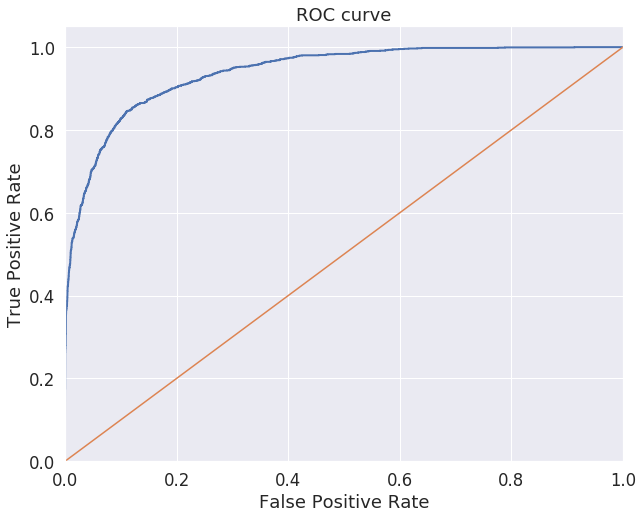

In [26]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = roc_curve(target_train, probabilities, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()